In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout,Activation,Conv2D, Concatenate, Dropout, BatchNormalization,MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('fer2013.csv')

X_train,y_train,X_test,y_test = [],[],[],[]

for index,row in df.iterrows():
    val = row['pixels'].split(" ")
    if 'Training' in row['Usage']:
        X_train.append(np.array(val,'float32'))
        y_train.append(row['emotion'])
    else:
        X_test.append(np.array(val,'float32'))
        y_test.append(row['emotion'])
        
X_train = np.array(X_train,'float32')
y_train = np.array(y_train,'float32')
X_test = np.array(X_test,'float32')
y_test = np.array(y_test,'float32')

y_train=to_categorical(y_train, num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


input_shape = Input(shape=(48,48,1))

initial = Conv2D(64,(3,3),padding='same')(input_shape)
initial = BatchNormalization()(initial)
initial = Activation('relu')(initial)
initial = Conv2D(64,(3,3),padding='same')(initial)
initial = BatchNormalization()(initial)
initial = Activation('relu')(initial)
initial = MaxPooling2D((2,2),strides=2,padding='same')(initial)
initial = BatchNormalization()(initial)

para_1 = Conv2D(128,(1,1),padding='same')(initial)
para_1 = BatchNormalization()(para_1)
para_1 = Activation('relu')(para_1)
para_1 = Conv2D(128,(3,3),padding='same')(para_1)
para_1 = BatchNormalization()(para_1)
para_1 = Activation('relu')(para_1)

para_2 = MaxPooling2D((3,3),strides=1,padding='same')(initial)
para_2 = Conv2D(128,(1,1),padding='same')(para_2)
para_2 = BatchNormalization()(para_2)
para_2 = Activation('relu')(para_2)
para_2 = Conv2D(128,(3,3),padding='same')(para_2)
para_2 = BatchNormalization()(para_2)
para_2 = Activation('relu')(para_2)

merge_p12 = Concatenate()([para_1,para_2])
merge_p12 = MaxPooling2D((2,2),strides=2,padding='same')(merge_p12)

para_3 = Conv2D(256,(1,1),padding='same')(merge_p12)
para_3 = BatchNormalization()(para_3)
para_3 = Activation('relu')(para_3)
para_3 = Conv2D(256,(3,3),padding='same')(para_3)
para_3 = BatchNormalization()(para_3)
para_3 = Activation('relu')(para_3)

para_4 = MaxPooling2D((3,3),strides=1,padding='same')(merge_p12)
para_4 = Conv2D(256,(1,1),padding='same')(para_4)
para_4 = BatchNormalization()(para_4)
para_4 = Activation('relu')(para_4)
para_4 = Conv2D(256,(3,3),padding='same')(para_4)
para_4 = BatchNormalization()(para_4)
para_4 = Activation('relu')(para_4)

merge_p34 = Concatenate()([para_3,para_4])
merge_p34 = MaxPooling2D((2,2),strides=2,padding='same')(merge_p34)

x = Conv2D(512,(1,1),padding='same')(merge_p34)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),strides=2,padding='same')(x)
x = Conv2D(512,(3,3),padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),strides=2,padding='same')(x)
x = AveragePooling2D((2,2),strides=1)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(7, activation='softmax')(x)

model = Model(input_shape,prediction)

model.compile(
   loss = 'categorical_crossentropy',
   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),
   metrics = ['accuracy'],
)

#checkpoint = ModelCheckpoint(filepath, verbose=1,monitor='val_acc',save_best_only=True,mode='max')
early_stop = EarlyStopping(monitor='val_loss',patience=50,verbose=1)
log_csv = CSVLogger('eXnet_logs.csv',separator=',',append=False)

callbacks_list = [early_stop, log_csv]

X = model.fit(
   X_train,y_train,
   validation_data = (X_test,y_test),
   epochs = 200,
   verbose=1,
   callbacks = callbacks_list,
)
 
fer_json = model.to_json()
with open("eXnet.json", "w") as json_file:
   json_file.write(fer_json)
model.save_weights("eXnet.h5")

Epoch 1/200
898/898 [==============================] - 27s 30ms/step - loss: 1.5160 - accuracy: 0.4043 - val_loss: 1.4972 - val_accuracy: 0.4143
Epoch 2/200
898/898 [==============================] - 27s 30ms/step - loss: 1.2407 - accuracy: 0.5261 - val_loss: 1.2980 - val_accuracy: 0.5166
Epoch 3/200
898/898 [==============================] - 27s 30ms/step - loss: 1.1102 - accuracy: 0.5749 - val_loss: 1.1171 - val_accuracy: 0.5770
Epoch 4/200
898/898 [==============================] - 27s 30ms/step - loss: 1.0108 - accuracy: 0.6151 - val_loss: 1.1190 - val_accuracy: 0.5755
Epoch 5/200
898/898 [==============================] - 27s 30ms/step - loss: 0.9171 - accuracy: 0.6549 - val_loss: 1.1194 - val_accuracy: 0.5836
Epoch 6/200
898/898 [==============================] - 27s 30ms/step - loss: 0.8248 - accuracy: 0.6895 - val_loss: 1.1048 - val_accuracy: 0.5997
Epoch 7/200
898/898 [==============================] - 27s 31ms/step - loss: 0.7301 - accuracy: 0.7260 - val_loss: 1.1954 - val_ac

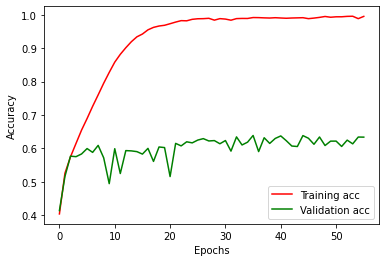

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
log = pd.read_csv('eXnet_logs.csv')
plt.plot(log['epoch'],log['accuracy'],'r',label='Training acc')
plt.plot(log['epoch'],log['val_accuracy'],'g',label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()